In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, StaticCovariatesTransformer, InvertibleMapper
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.models import LightGBMModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from tqdm import tqdm
import sklearn

import warnings
warnings.filterwarnings("ignore")



c:\Users\erent\anaconda3\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


- Sales Forecasting for Ecuadorian Stores
 
- Our goal is to predict future sales of stores located in Ecuador for the dates August 16, 2017, to August 31, 2017. 

- We will be forecasting sales for 33 product families across 54 stores.

## Loading the data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_holiday_events = pd.read_csv('data/holidays_events.csv')
df_stores = pd.read_csv("data/stores.csv")
df_oil = pd.read_csv("data/oil.csv")
df_transactions = pd.read_csv("data/transactions.csv")
df_test = pd.read_csv("data/test.csv")
df_sample_submission = pd.read_csv("data/sample_submission.csv")

# Be sure they are datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

### df_train : 

- id – the index of the row
- date – the current date
- store_nbr – the store id
- family – the product family
- sales – number of sales in this family
- onpromotion – the number of products on promotion in this family

### df_holidays_events :

- date – the date of the holiday
- type – the type of holiday (Holiday, Event, Transfer (see transferred column), Additional, Bridge, Work Day)
- locale – the scope of the event (Local, Regional, National)
- locale_name – the city where the event takes place
- description – name of the event
- transferred – whether the event has been transferred (moved to another day) or not

### df_stores :

- store_nbr – the store id 
- city – the city where the store is located
- state – the state where the store is located
- type – the type of the store
- cluster – the number of similar stores in the vicinity

### df_oil :

- date – the date
- dcoilwtico – crude oil price

### df_transactions : 

- date – the date
- store_nbr – the store id 
- transactions – the number of transactions that have occurred in the store on the date

In [63]:
display(df_train.head(), df_holiday_events.head(), df_stores.head(), df_oil.head(), df_transactions.head(), df_test.head(), df_sample_submission.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## Preprocessing the data

In [4]:
family_list = df_train['family'].unique()       # 33 families
store_list = df_stores['store_nbr'].unique()    # 54 stores 

In [5]:
# We will merge because we need the city and state information

display(df_train, df_stores.tail())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [6]:
# 1. Merge train and store data
# 2. Sort the merged data by store_nbr, family, and date
# 3. Convert store_nbr, family, city, state, type, and cluster to string

train_merged = pd.merge(df_train, df_stores, on="store_nbr")
train_merged = train_merged.sort_values(["store_nbr", "family", "date"])   
train_merged = train_merged.astype(
    {
        "store_nbr": "str",
        "family": "str",
        "city": "str",
        "state": "str",
        "type": "str",
        "cluster": "str",
    }
)
train_merged

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
2778467,2993627,2017-08-11,54,SEAFOOD,0.0,0,El Carmen,Manabi,C,3
2778500,2995409,2017-08-12,54,SEAFOOD,1.0,1,El Carmen,Manabi,C,3
2778533,2997191,2017-08-13,54,SEAFOOD,2.0,0,El Carmen,Manabi,C,3
2778566,2998973,2017-08-14,54,SEAFOOD,0.0,0,El Carmen,Manabi,C,3


In [7]:
# Arrange the test data for later

df_test_dropped = df_test.drop(['onpromotion'], axis=1)     # we will handle onpromotion when future covariates are added
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family','date'])

df_test_sorted.head()   

,id,date,store_nbr,family
0,3000888,2017-08-16,1,AUTOMOTIVE
1782,3002670,2017-08-17,1,AUTOMOTIVE
3564,3004452,2017-08-18,1,AUTOMOTIVE
5346,3006234,2017-08-19,1,AUTOMOTIVE
7128,3008016,2017-08-20,1,AUTOMOTIVE


In [8]:
# TimeSeries objects for each product family
family_TS_dict = {}

# Loop through each family
for family in family_list:

    # Get the rows for the current family
    df_family = train_merged[train_merged["family"] == family]

    # Convert the df into a list of TimeSeries objects
    list_of_TS_family = TimeSeries.from_group_dataframe(
        df_family,
        time_col="date",
        group_cols=["store_nbr"],  # TimeSeries for each store in the current family
        static_cols=[
            "city",
            "state",
            "type",
            "cluster",
        ],  # Columns to use as static covariates
        value_cols="sales",
        fill_missing_dates=True,  # there are missing dates in the data
        freq="D",  # daily frequency
    )

    # make value type float32 for efficiency
    list_of_TS_family = [ts.astype(np.float32) for ts in list_of_TS_family]

    # Sort by the 'store_nbr'. 
    # static_covariates_values()[0, 0] is the store_nbr 
    list_of_TS_family = sorted(
        list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0, 0])  # convert to int for sorting
    )

    # Add the sorted list of TimeSeries objects to the dictionary under the current family key
    family_TS_dict[family] = list_of_TS_family

In [9]:
family_pipeline_dict = {}
family_TS_transformed_dict = {}

# Iterate over each family's time series
for family, time_series in family_TS_dict.items():  # family is the key, time_series is the value
    
    # Fill missing values in the time series
    train_filler = MissingValuesFiller(
        verbose=False,  # verbose means it will print out the steps it's taking
        n_jobs=-1,
        name="Fill NAs",
    )

    # One-hot encoding for the static covariates
    static_cov_transformer = StaticCovariatesTransformer(   # static covariates are the store_nbr, city, state, type, and cluster
        verbose=False,
        transformer_cat=sklearn.preprocessing.OneHotEncoder(),
        name="Encoder",
    )

    # Apply a log transformation to the data to help with normalizing the distribution
    log_transformer = InvertibleMapper(
        np.log1p,  # helps with the skewness of the data
        np.expm1,   # inverse of the log transformation
        verbose=False,
        n_jobs=-1,
        name="Log-Transform",
    )

    # Scale the time series data 
    train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

    # Create a pipeline of transformations to apply to the time series
    train_pipeline = Pipeline(
        [train_filler, static_cov_transformer, log_transformer, train_scaler]
    )

    # Apply the pipeline to the time series for the current family
    training_transformed = train_pipeline.fit_transform(time_series)

    # Store the pipeline and transformed time series in their respective dictionaries
    family_pipeline_dict[family] = train_pipeline
    family_TS_transformed_dict[family] = training_transformed

 #### Time covariates :
 
 - year – year
 - month – month
 - day – day
 - dayofyear – day of the year (for example February 1 is the 32nd day of the year)
 - weekday – day of the week (1 - 7)
 - weekofyear – week of the year (1 - 52 )
 - timesteps – the index of the interval

In [10]:
# Create a Time Covariate   

# it contains the year, month, day, dayofyear, weekday, weekofyear, and timesteps (which is the number of days since the start of the time period)

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")

timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),   # it arranges the values from 0 to the length of the time period
                                             columns=["linear_increase"])   

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)  # stack the covariates  
time_cov = time_cov.astype(np.float32)

In [11]:
# Normalize the time covariates

time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))  # split the time covariates into training and validation sets
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

#### Oil covariates are : 

- oil price moving average of 7 days
- oil price moving average of 14 days
- oil price moving average of 28 days

In [12]:
# Convert the oil DataFrame to a Darts TimeSeries for easier manipulation
oil_ts = TimeSeries.from_dataframe(
    df_oil, time_col="date", value_cols=["dcoilwtico"], freq="D"
).astype(np.float32)

# Create a pipeline of preprocessing steps
# 1. Fill missing values
# 2. Scale the data
oil_pipeline = Pipeline(
    [
        MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs"),
        Scaler(verbose=False, n_jobs=-1, name="Scaler"),
    ]
)

# Apply the preprocessing pipeline to the oil TimeSeries
oil_transformed = oil_pipeline.fit_transform(oil_ts)

# Calculate moving averages with 7 and 28-day windows
ma_7 = MovingAverageFilter(7).filter(oil_transformed)
ma_14 = MovingAverageFilter(14).filter(oil_transformed)
ma_28 = MovingAverageFilter(28).filter(oil_transformed)

# Combine the 7 , 14, and 28-day moving averages into a single TimeSeries
oil_moving_averages = ma_7.stack(ma_14).stack(ma_28)

#### Holiday covariates are :
 - national_holiday
 - earthquake_relief
 - christmas
 - football_event
 - national_event
 - work_day
 - local_holiday

In [13]:
def holiday_list(df_holidays_events, df_stores):
    """
    
    Generates a list of DataFrames with binary indicators for various holiday types for each store.
    
    """
    holiday_series_list = []  # Renamed for clarity
    
    for i, store in df_stores.iterrows():  # Iterate directly over stores
        df_holiday_indicators = pd.DataFrame(df_holidays_events['date'].unique(), columns=['date'])  # Ensure unique dates
        
        # Simplify conditions by using direct assignment
        df_holiday_indicators['national_holiday'] = 0
        df_holiday_indicators['earthquake_relief'] = 0
        df_holiday_indicators['christmas'] = 0
        df_holiday_indicators['football_event'] = 0
        df_holiday_indicators['national_event'] = 0
        df_holiday_indicators['work_day'] = 0
        df_holiday_indicators['local_holiday'] = 0
        
        # Filter events based on conditions and set indicators
        for _, event in df_holidays_events.iterrows():
            if event['type'] == 'Holiday' and event['locale'] == 'National':
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'national_holiday'] = 1
            if 'Terremoto Manabi' in event['description']:
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'earthquake_relief'] = 1
            if 'Navidad' in event['description']:
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'christmas'] = 1
            if 'futbol' in event['description']:
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'football_event'] = 1
            if event['type'] == 'Event' and event['locale'] == 'National' and 'Terremoto Manabi' not in event['description'] and 'futbol' not in event['description']:
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'national_event'] = 1
            if event['type'] == 'Work Day':
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'work_day'] = 1
            if event['type'] == 'Holiday' and (event['locale_name'] == store['state'] or event['locale_name'] == store['city']):
                df_holiday_indicators.loc[df_holiday_indicators['date'] == event['date'], 'local_holiday'] = 1
        
        holiday_series_list.append(df_holiday_indicators)

    return holiday_series_list

def remove_0_and_duplicates(holiday_series_list):
    """
    
    Cleans the holiday data by removing entries with all zeros and duplicates.
    
    """
    cleaned_series_list = []
    
    for df_holiday in holiday_series_list:
        # Already unique dates, just ensure no entire row of zeros
        df_holiday = df_holiday.loc[df_holiday.drop('date', axis=1).sum(axis=1) > 0]
        cleaned_series_list.append(df_holiday)

    return cleaned_series_list

def holiday_TS_list_54(holiday_series_list):
    """
    
    Converts the cleaned list of holiday DataFrames into TimeSeries objects for further processing.
    
    """
    ts_list = []
    
    for df_holiday in holiday_series_list:
        ts = TimeSeries.from_dataframe(df_holiday, time_col='date', fill_missing_dates=True, fillna_value=0, freq='D')
        ts = ts.slice(pd.Timestamp('20130101'), pd.Timestamp('20170831')).astype(np.float32)
        ts_list.append(ts)

    return ts_list

# Processing flow
list_of_holidays_per_store = holiday_list(df_holiday_events, df_stores)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_transformed = Pipeline([holidays_filler, holidays_scaler]).fit_transform(list_of_holidays_store)

In [14]:
display(len(holidays_transformed))
display(holidays_transformed[0].components.values)

54

array(['national_holiday', 'earthquake_relief', 'christmas',
       'football_event', 'national_event', 'work_day', 'local_holiday'],
      dtype=object)

### Promotion covariates are :
- promotion 
- promotion moving average of 7 days
- promotion moving average of 28 days

In [15]:
df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])

In [16]:
df_promotion

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01 00:00:00,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02 00:00:00,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03 00:00:00,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04 00:00:00,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05 00:00:00,1,AUTOMOTIVE,5.0,0
...,...,...,...,...,...,...
21251,3022139,2017-08-27,54,SEAFOOD,NaN,0
23033,3023921,2017-08-28,54,SEAFOOD,NaN,0
24815,3025703,2017-08-29,54,SEAFOOD,NaN,0
26597,3027485,2017-08-30,54,SEAFOOD,NaN,0


In [17]:

# Ensure the 'date' column is in datetime format
df_promotion['date'] = pd.to_datetime(df_promotion['date'])

# Proceed with processing
family_promotion_dict = {}

for family in family_list:
    df_family_promo = df_promotion[df_promotion['family'] == family]
    
    # Ensure the 'date' column is in datetime format for safety
    df_family_promo['date'] = pd.to_datetime(df_family_promo['date'])

    # Convert promotion data into a list of TimeSeries objects, one per store
    list_of_TS_promo = TimeSeries.from_group_dataframe(df_family_promo,
                                                       time_col='date',
                                                       group_cols=['store_nbr'],
                                                       value_cols='onpromotion',
                                                       fill_missing_dates=True,
                                                       freq='D')
    
    # Preprocess the promotion TimeSeries
    promo_pipeline = Pipeline([
        MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs"),
        Scaler(verbose=False, n_jobs=-1, name="Scaling")
    ])
    promotion_transformed = promo_pipeline.fit_transform(list_of_TS_promo)
    
    # Compute 7-day and 28-day moving averages for promotions
    moving_averages_7d = [MovingAverageFilter(window=7).filter(ts) for ts in promotion_transformed]
    moving_averages_28d = [MovingAverageFilter(window=28).filter(ts) for ts in promotion_transformed]
    
    # Combine original promotions with their moving averages
    promotion_with_moving_averages = [ts.stack(ma7).stack(ma28) for ts, ma7, ma28 in zip(promotion_transformed, moving_averages_7d, moving_averages_28d)]
    
    # Store the combined TimeSeries in the dictionary under the respective family key
    family_promotion_dict[family] = promotion_with_moving_averages


### Stacking future covariates 

In [18]:
# Create a dictionary to store the pipelines and transformed TimeSeries
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

In [19]:
# Create a list to store the transformed TimeSeries for each store

store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)  
  store_covariates_future.append(stacked_covariates)

In [20]:
future_covariates_dict = {}

for key in tqdm(family_promotion_dict):
    promotion_family = family_promotion_dict[key]
    covariates_future = []

    for i in range(len(promotion_family)):
        # Access the promotion TimeSeries for the current index
        promo_ts = promotion_family[i]
        
        # Access the corresponding store covariates TimeSeries
        store_ts = store_covariates_future[i]
        
        # Convert both TimeSeries to pandas DataFrames for easier manipulation
        promo_df = promo_ts.pd_dataframe()
        store_df = store_ts.pd_dataframe()
        
        combined_df = promo_df.merge(store_df, left_index=True, right_index=True, how='outer')
        
        # Fill any resulting NaNs that might appear due to outer join
        combined_df.fillna(0, inplace=True)
        
        # Convert the combined DataFrame back to a TimeSeries object
        combined_ts = TimeSeries.from_dataframe(combined_df)
        
        covariates_future.append(combined_ts)

    future_covariates_dict[key] = covariates_future


100%|██████████| 33/33 [00:06<00:00,  5.11it/s]


In [21]:
display(future_covariates_dict['AUTOMOTIVE'][0].components)

Index(['onpromotion', 'rolling_mean_7_onpromotion',
       'rolling_mean_28_onpromotion', 'national_holiday', 'earthquake_relief',
       'christmas', 'football_event', 'national_event', 'work_day',
       'local_holiday', 'year', 'month', 'day', 'dayofyear', 'dayofweek',
       'weekofyear', 'linear_increase', 'dcoilwtico',
       'rolling_mean_7_dcoilwtico', 'rolling_mean_14_dcoilwtico',
       'rolling_mean_28_dcoilwtico'],
      dtype='object', name='component')

### Transactions past covariates are :
- transactions amount per store for a past date

In [22]:
df_transactions.sort_values(["store_nbr", "date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
    df_transactions,
    time_col="date",
    group_cols=["store_nbr"],
    value_cols="transactions",
    fill_missing_dates=True,
    freq="D",
)

transactions_list = []

for ts in TS_transactions_list:
    series = TimeSeries.from_series(ts.pd_series())
    series = series.astype(np.float32)
    transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(  
    start_ts=pd.Timestamp("20130102"), end_ts=pd.Timestamp("20170815")
)

from datetime import datetime, timedelta

transactions_list_full = []

for ts in transactions_list:
    if ts.start_time() > pd.Timestamp("20130101"):
        end_time = ts.start_time() - timedelta(days=1)
        delta = end_time - pd.Timestamp("20130101")
        zero_series = TimeSeries.from_times_and_values(
            times=pd.date_range(start=pd.Timestamp("20130101"), end=end_time, freq="D"),
            values=np.zeros(delta.days + 1),
        )
        ts = zero_series.append(ts)
        ts = ts.with_columns_renamed(
            col_names=ts.components, col_names_new="transactions"
        )
        transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

## Model :


In [57]:
def train_lightgbm_models_per_family(family_list, time_series_per_family, future_covariates_per_family, transformed_transactions, model_parameters):
    """
    This function does the followings:
    - Trains a LightGBM model for each product family.
    - Returns a dictionary mapping each family name to its trained LightGBM model.

    Parameters:
    - family_list (List[str]): List of product family names.
    - time_series_per_family (Dict[str, List[TimeSeries]]): Mapping of each family to its list of TimeSeries objects.
    - future_covariates_per_family (Dict[str, List[TimeSeries]]): Mapping of each family to its future covariates TimeSeries objects.
    - transformed_transactions (TimeSeries): TimeSeries object of preprocessed transaction data.
    - model_parameters (dict): Configuration parameters for the LightGBMModel.

    Returns:
    - Dict[str, LightGBMModel]: A dictionary mapping each family name to its trained LightGBM model.
    """
    trained_models_per_family = {}

    for family_name in tqdm(family_list, desc="Training models for each family"):
        sales_time_series = time_series_per_family[family_name]
        training_series = [series for series in sales_time_series]
        family_future_covariates = future_covariates_per_family[family_name]
        aligned_training_series = [training_series[i].slice_intersect(family_future_covariates[i]) for i in range(len(training_series))]

        # Initialize the LightGBM model with specified parameters
        lightgbm_model = LightGBMModel(**model_parameters)

        # Train the model using the family's sales time series and covariates
        lightgbm_model.fit(series=aligned_training_series, 
                           future_covariates=family_future_covariates,
                           past_covariates=transformed_transactions,
                           verbose=False)

        # Save the trained model for the family
        trained_models_per_family[family_name] = lightgbm_model

    return trained_models_per_family


In [58]:
def predict_sales_per_family_with_lightgbm(family_names, time_series_per_family, future_covariates_per_family, transformed_transactions, trained_models_per_family):
    """
    This function does the following:
    - Predicts sales for each product family using the trained LightGBM models.
    - Stores the forecasted sales in a dictionary.

    Parameters:
    - family_names (List[str]): List of product family names.
    - time_series_per_family (Dict[str, List[TimeSeries]]): Mapping of each family to its list of TimeSeries objects.
    - future_covariates_per_family (Dict[str, List[TimeSeries]]): Mapping of each family to its future covariates TimeSeries objects.
    - transformed_transactions (TimeSeries): TimeSeries object of preprocessed transaction data.
    - trained_models_per_family (Dict[str, LightGBMModel]): Mapping of each family to its trained LightGBM model.

    Returns:
    - Dict[str, TimeSeries]: A dictionary mapping each family name to its forecasted sales TimeSeries object.
    """
    forecasts_per_family = {}

    for family_name in tqdm(family_names, desc="Predicting sales for each family"):
        sales_time_series = time_series_per_family[family_name]
        aligned_series = [series for series in sales_time_series]
        family_future_covariates = future_covariates_per_family[family_name]
        aligned_series_with_covariates = [aligned_series[i].slice_intersect(family_future_covariates[i]) for i in range(len(aligned_series))]

        # Generate forecasts using the trained model for the current family
        family_forecasts = trained_models_per_family[family_name].predict(
            n=16,
            series=aligned_series_with_covariates,
            future_covariates=family_future_covariates,
            past_covariates=transformed_transactions,
            verbose=False
        )

        # Store the forecasted sales
        forecasts_per_family[family_name] = family_forecasts
    
    return forecasts_per_family


In [68]:
def create_submission_df( family_list, lgbm_forecasts_families_submission, df_test_sorted):
  """
  This function does the following:
  - Inverse transforms the forecasts for each family.
  - Removes negative forecasts.
  - Concatenates the forecasts into a single dataframe.
  - Sorts the dataframe by 'id'.
  - Drops the 'date', 'store_nbr', and 'family' columns.
  - Renames the 'fcast' column to 'sales'.
  - Resets the index of the dataframe.
     
  Parameters:
  - family_list: List of product families.
  - lgbm_forecasts_families_submission: Dictionary mapping each family to its forecasts.
  - df_test_sorted: Sorted test data.
  Returns:
  - A dataframe with the forecasts for the Kaggle competition.
  """

  LGBM_Forecasts_Families_back_Submission = {}
  for family in tqdm(family_list):
          
      LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(lgbm_forecasts_families_submission[family], partial=True)
  
  for family in tqdm(LGBM_Forecasts_Families_back_Submission):
    for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
      if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
          LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
  
  listofseries = []
  
  for store in tqdm(range(0,54)):
    for family in family_list:
        oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
        oneforecast.columns = ['fcast']
        listofseries.append(oneforecast)
  
  df_forecasts = pd.concat(listofseries) 
  df_forecasts.reset_index(drop=True, inplace=True)
  
  # No Negative Forecasts
  df_forecasts[df_forecasts < 0] = 0
  forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)

  forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)
  
  return forecasts_kaggle_sorted



In [62]:
lgbm_params = {
    'lags': 63,
    'multi_models': True, 
    'lags_future_covariates': (14, 1),      
    'lags_past_covariates': [-16, -17, -18, -19, -20, -21, -22],     
    'output_chunk_length': 1,   
    'random_state': 42,
    'gpu_use_dp': "true",
}

trained_models = train_lightgbm_models_per_family(
    family_list, 
    family_TS_transformed_dict, 
    future_covariates_dict, 
    transactions_transformed, 
    lgbm_params
)

Training models for each family: 100%|██████████| 33/33 [02:45<00:00,  5.02s/it]


In [107]:
# call the function
forecasts = predict_sales_per_family_with_lightgbm(
    family_list, 
    family_TS_transformed_dict, 
    future_covariates_dict, 
    transactions_transformed, 
    trained_models
)

Predicting sales for each family: 100%|██████████| 33/33 [00:18<00:00,  1.75it/s]


In [69]:
submission_df = create_submission_df(family_list, forecasts, df_test_sorted)

100%|██████████| 54/54 [00:00<00:00, 78.26it/s]


In [70]:
submission_df.to_csv('submission.csv', index=False)

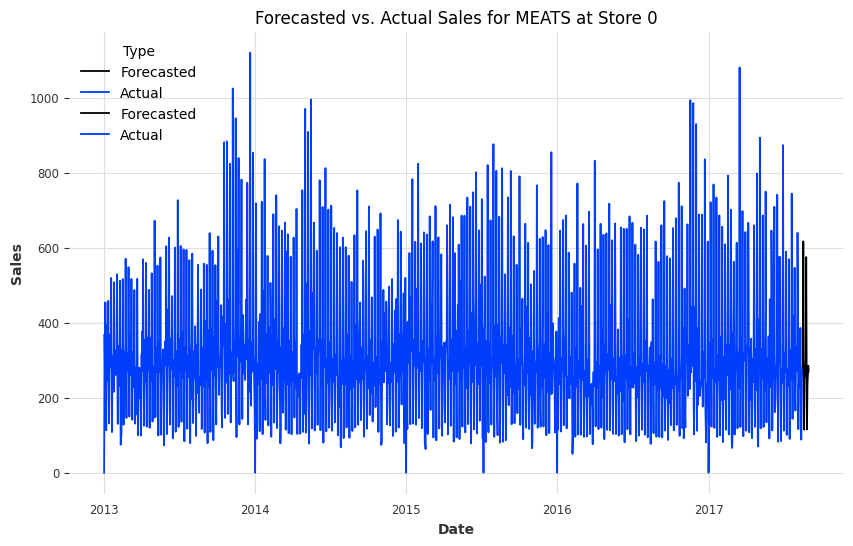

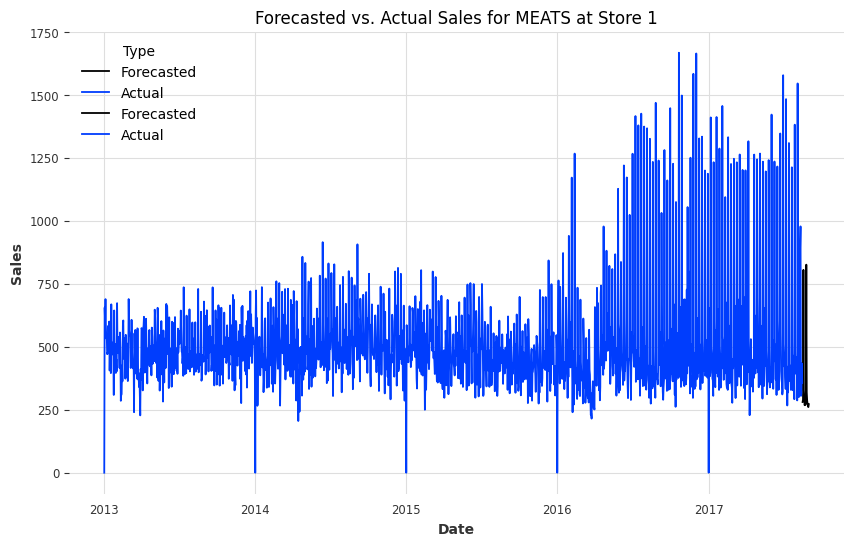

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

family = 'MEATS'  # Choose a family to visualize

# Plot the forecasted sales for each family at store 0, 1, and 2 for visualization
for store in range(0, 2):
    # Inverse transform forecasts and convert to DataFrame
    forecast_df = family_pipeline_dict[family].inverse_transform(forecasts[family][store], partial=True).pd_dataframe()
    forecast_df.rename(columns={forecast_df.columns[0]: 'Forecasted Sales'}, inplace=True)
    forecast_df['Type'] = 'Forecasted'
    
    # Convert actual sales to DataFrame
    actual_df = family_TS_dict[family][store].pd_dataframe()
    actual_df.rename(columns={actual_df.columns[0]: 'Actual Sales'}, inplace=True)
    actual_df['Type'] = 'Actual'
    
    # Combine both DataFrames for plotting
    combined_df = pd.concat([forecast_df, actual_df])

    # Plot the combined DataFrame
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_df, x=combined_df.index, y='Forecasted Sales', hue='Type')
    sns.lineplot(data=combined_df, x=combined_df.index, y='Actual Sales', hue='Type')
    plt.title(f'Forecasted vs. Actual Sales for {family} at Store {store}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()


